In [1]:
import matplotlib.pyplot as plt

In [5]:
print('Loading modules...')

import os, sys, getopt, datetime
import pickle as pkl
import pandas as pd
import numpy as np

from xgboost import XGBRegressor, XGBClassifier
from dairyml import XGBCombined

from skll.metrics import spearman, pearson
from sklearn.utils import shuffle
from sklearn.model_selection import cross_validate, RepeatedKFold
from sklearn.metrics import r2_score, mutual_info_score, make_scorer, mean_absolute_error, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

from keras.models import load_model

import warnings
warnings.filterwarnings("ignore")

#Load the model, pretrained on the full training data
model_path = '../models/xgb_combined.model'
print('Loading model at {}'.format(model_path))
if 'ffnn' in model_path:
    model = load_model(model_path)
else:
    with open(model_path, "rb" ) as f:
        model = pkl.load(f)

#Load test data
data_path = '../data/training_for_GS_122118.csv'
print('Loading data at {}'.format(data_path))
data = pd.read_csv(data_path)
data = data.set_index('FoodCode')
numerical_features = data.columns[1:-1]

# with open("../pkl/data/data_outliers_removed", "rb" ) as f:
#     [X, Y] = pkl.load(f)
    
#Scale the features to 0 mean and unit variance
print('Scaling input features...')
ss = StandardScaler()
X = pd.DataFrame(ss.fit_transform(data[numerical_features]),columns=data[numerical_features].columns,index=data.index)

# get the target variable
Y = data['lac.per.100g']
Y_binary = (Y != 0)

#list scoring measure names and functions
scoring_full = {'r2':r2_score, 
   'SRC':spearman, 
   'PCC':pearson, 
   'MI':mutual_info_score, 
   'MAE':mean_absolute_error}

scoring_clf = {'classifier_accuracy': accuracy_score, 
   'classifier_f1': f1_score }

results_dir = '../reports/'

results = pd.DataFrame()

if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# Get model predictions
print('Testing the model... ')
# full predictions
predictions = pd.DataFrame()

predictions['Y'] = Y #actual values
# print(model.predict(X))
Y_pred = np.reshape(model.predict(X),(-1,len(Y)))[0] #overall prediction

predictions['Y_pred'] = Y_pred

predictions['Y_pred_reg'] = np.nan
predictions['Y_pred_clas'] = np.nan

try:
    Y_pred_reg = model.reg.predict(X) # regressor predictions (combined models only)
    predictions['Y_pred_reg'] = Y_pred_reg
    Y_pred_clas = model.clas.predict(X) #classifier predictions (combined models only)
    predictions['Y_pred_clas'] = Y_pred_clas
except AttributeError:
    pass

model_name = os.path.basename(model_path)

#score the predictions
print('\nResults: ')
for name, metric in scoring_full.items():
    score = np.round(metric(Y,Y_pred),2)
    print('{}: {}'.format(name,score))
    results.loc[model_name,name] = score

print(results)

if not all(np.isnan(predictions['Y_pred_clas'])):
    for name, metric in scoring_clf.items():
        score = np.round(metric(Y_binary,predictions['Y_pred_clas']),2)
        print('{}: {}'.format(name,score))
        results.loc[model_name,name] = score
else:
    for name, metric in scoring_clf.items():
        score = np.nan
        print('{}: {}'.format(name,score))
        results.loc[model_name,name] = score

# #store the results
# time = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
# results_path = 'reports/test_results_'+time+'.csv'
# predictions_path = 'reports/test_predictions_'+time+'.csv'

# results.to_csv(results_path)
# predictions.to_csv(predictions_path)
# print('\nResults saved to {}'.format(results_path))
# print('\nPredictions saved to {}'.format(predictions_path))

Loading modules...
Loading model at ../models/xgb_combined.model
Loading data at ../data/training_for_GS_122118.csv
Scaling input features...
Testing the model... 

Results: 
r2: 0.74
SRC: 0.99
PCC: 0.86
MI: 4.48
MAE: 0.15
                      r2   SRC   PCC    MI   MAE
xgb_combined.model  0.74  0.99  0.86  4.48  0.15
classifier_accuracy: 1.0
classifier_f1: 1.0


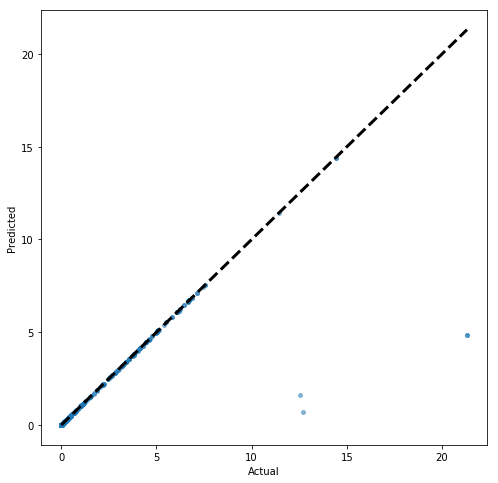

In [6]:
fig, ax = plt.subplots(figsize=[8,8])
ax.scatter(Y, Y_pred, s=15, alpha=0.5)
ax.plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'k--', lw=3)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.show()